In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags

In [4]:
class CoreDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, lags: int):
        # start from 1948
        core: pd.DataFrame = df[["CPIAUCSL", "UNRATE", "A191RO1Q156NBEA"]].loc["1948-01-01":]
        
        X = get_lags(core, lags)
        self.y = core[lags:].values
        self.X = X[lags:].values
        
    def __getitem__(self, index):
        return self.y[index], self.X[index]
    
    def __len__(self):
        return len(self.y)
    
    def plot(self):
        plt.plot(self.core)
        plt.show()

full = pd.read_csv('growth_rate.csv', index_col=0, header=[0], parse_dates=True)
coreDataset = CoreDataset(full, lags=3)
print(len(coreDataset))

850


In [5]:
windows = []
train_size = 400
val_size = 100
test_from = 700
train_start = 0

# reserve test set first
testset = Subset(coreDataset, [i for i in range(test_from + 1, len(coreDataset))])
testloader = DataLoader(testset, batch_size=1, shuffle=False, sampler=SequentialSampler(testset))

class Window:
    
    def __init__(self, trainloader, validationloader):
        self.trainloader = trainloader
        self.validationloader = validationloader

# generate training windows
while train_start + train_size + val_size <= test_from:
    train_end = train_start + train_size
    print("Generating training set from: %d to %d" % (train_start, train_end))
    trainset = Subset(coreDataset, [i for i in range(train_start, train_end)])
    
    val_start = train_end + 1
    val_end = train_end + val_size
    print("Generating validation set from %d to %d" % (val_start, val_end))
    valset = Subset(coreDataset, [i for i in range(val_start, val_end)])
    
    train_start += 100
    
    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))
    
    windows.append(Window(trainloader=trainloader, validationloader=validationloader))

print(str(len(windows)) + " windows generated")

Generating training set from: 0 to 400
Generating validation set from 401 to 500
Generating training set from: 100 to 500
Generating validation set from 501 to 600
Generating training set from: 200 to 600
Generating validation set from 601 to 700
3 windows generated


In [6]:
class Feedforward(nn.Module):
    
    def __init__(self):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(9, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation at output layer
        return x
    
net = Feedforward()

In [7]:
criterion = nn.MSELoss()
# decreasing the learning rate solved the problem
# https://stackoverflow.com/questions/35540269/keras-giving-same-loss-on-every-epoch
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [8]:
# TODO move to utils
def evaluate_model(net: nn.Module, val_loader: DataLoader, criterion: nn.MSELoss):
    net.eval()
    val_loss = 0
    for i, data in enumerate(val_loader):
        with torch.no_grad():
            y, X = data
            y, X = y.float(), X.float()
            y_pred = net(X)
            loss = criterion(y, y_pred)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def train_one_epoch(net: nn.Module, train_loader: DataLoader, criterion: nn.MSELoss):
    net.train()
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        
        y, X = data
        y, X = y.float(), X.float()
        
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y, y_pred)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_train_loss = epoch_loss / len(train_loader)
    return avg_train_loss
    

def get_average(losses: list):
    total = 0
    for i in losses:
        total += i
    return total/len(losses)


In [25]:
# early stopping implementation
# inspired by https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

def train_window(net: nn.Module, criterion: nn.MSELoss, window):
    running_val_loss = []
    prev_val_loss = 1000000  # very big number
    cnt = 0
    patience = 10
    ma = 5
    
    for epoch in range(5000):
            
        train_loss = train_one_epoch(net, window.trainloader, criterion)
        val_loss = evaluate_model(net, window.validationloader, criterion)
        running_val_loss.append(val_loss)
        
        if epoch % 5 == 0:
            print("[epoch: %d] train loss: %.3f, val loss: %.3f"
                  % (epoch + 1, train_loss, val_loss))
        
        avg_val_loss = get_average(running_val_loss)
    
        if avg_val_loss > prev_val_loss:
            if cnt > patience:
                break
            else:
                cnt += 1
        else:
            cnt = 0  # reset
            
        prev_val_loss = avg_val_loss
        
        # restrict to moving average
        while len(running_val_loss) > ma:
            running_val_loss.pop(0)
                
    print("Finished window")


for i, window in enumerate(windows):
    print("Training in window " + str(i + 1))
    train_window(net, criterion, window)

print("Finished training")

Training in window 1
[epoch: 1] train loss: 3.773, val loss: 7.498
[epoch: 6] train loss: 0.420, val loss: 2.045
[epoch: 11] train loss: 0.334, val loss: 1.815
[epoch: 16] train loss: 0.278, val loss: 1.683
[epoch: 21] train loss: 0.249, val loss: 1.598
[epoch: 26] train loss: 0.234, val loss: 1.545
[epoch: 31] train loss: 0.225, val loss: 1.463
[epoch: 36] train loss: 0.217, val loss: 1.429
[epoch: 41] train loss: 0.211, val loss: 1.377
[epoch: 46] train loss: 0.207, val loss: 1.336
[epoch: 51] train loss: 0.203, val loss: 1.319
[epoch: 56] train loss: 0.199, val loss: 1.263
[epoch: 61] train loss: 0.195, val loss: 1.274
[epoch: 66] train loss: 0.191, val loss: 1.214
[epoch: 71] train loss: 0.188, val loss: 1.179
[epoch: 76] train loss: 0.184, val loss: 1.142
[epoch: 81] train loss: 0.182, val loss: 1.151
[epoch: 86] train loss: 0.181, val loss: 1.108
[epoch: 91] train loss: 0.180, val loss: 1.085
[epoch: 96] train loss: 0.178, val loss: 1.069
[epoch: 101] train loss: 0.177, val loss:

In [23]:
# to reset the weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
    
net.apply(init_weights)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


Feedforward(
  (fc1): Linear(in_features=9, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=3, bias=True)
)

Average MSE on test set: 0.8956331309281139


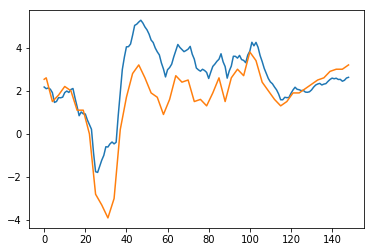

In [27]:
y_pred = []
y_act = []
running_test_loss = []

for i, data in enumerate(testloader):
    with torch.no_grad():
        y, X = data
        y, X = y.float(), X.float()
        
        loss = criterion(y, net(X))
        running_test_loss.append(loss.item())
    
        y_pred.append(net(X)[0][2].item())
        y_act.append(y[0][2].item())
    
plt.plot(y_pred)
plt.plot(y_act)

print("Average MSE on test set: " + str(get_average(running_test_loss)))
